In [59]:
import librosa
import IPython.display
import numpy as np
import matplotlib as plt
import matplotlib.pyplot as plt
import math

from scipy import signal
from scipy.fftpack import fft, fftshift

In [60]:
base_file = 'music/wav/pianoscale.wav' #file used to to reference autotune for other file
target_file = 'music/wav/clarinetnote.wav' #file that gets autotuned

In [61]:
y, sr = librosa.load(base_file, sr = 44100) #loading base
base = y
y, sr = librosa.load(target_file, sr = 44100) #loading target
target = y


triangle = signal.triang(44100)

In [62]:
IPython.display.Audio(data=base, rate=sr)

In [63]:
IPython.display.Audio(data=target, rate=sr)

In [64]:
pitches, magnitudes = librosa.core.piptrack(y=base,sr=sr) #pitch & magnitudes over time for base
pitchesOfBase = pitches
magnitudesOfBase = magnitudes

pitches, magnitudes = librosa.core.piptrack(y=target,sr=sr) #pitch & magnitudes over time for target
pitchesOfTarget = pitches
magnitudesOfTarget = magnitudes

print(target.shape)
print(pitchesOfBase.shape)

(352800,)
(1025, 690)


In [65]:
def detect_pitch(y, sr, t, name,name1): #used to get main pitch at certain time (t)
  index = name1[:, t].argmax()
  pitch = name[index, t]

  return pitch


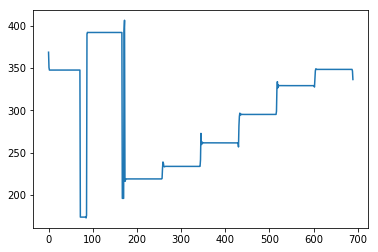

In [71]:
pitch_graph_base = np.empty(pitchesOfBase.shape[1]) #initializes empty array with dimensions of main pitches over time
pitch_graph_target = np.empty(pitchesOfTarget.shape[1])#initializes empty array with dimensions of main pitches over time

for i in range(pitchesOfBase.shape[1]):
    pitch_graph_base[i] = detect_pitch(base,sr,i,pitchesOfBase,magnitudesOfBase) #loading pitches
    
for i in range(pitchesOfTarget.shape[1]):
    pitch_graph_target[i] = detect_pitch(target,sr,i,pitchesOfTarget,magnitudesOfTarget) #loading pitches
    

data_base = pitch_graph_base
data_target = pitch_graph_target



plt.plot(data_base)
plt.show()




    





In [67]:
def f2midi(frequency): #frequency to midi
    if frequency == 0:
        return 10
    else:
        return int(69 + (12 * ((math.log(frequency/440)) / (math.log(2)))))

def midi2note(midi_num): #midi to note
    notes = ['C','C#','D','D#','E','F','F#','G','G#','A','A#','B']
    octave = int(math.floor(midi_num/12))
    index = int(midi_num % 12)
    final = notes[index] + str(octave)
    return final
    
def stepDistance(f1,f2): #calculating semi tones between frequencies
    return f2midi(f1) - f2midi(f2)



[-8. -7. -7. -7. -7. -7. -7. -7. -7. -7. -7. -7. -7. -7. -7. -7. -7. -7.
 -7. -7. -7. -7. -5. -5. -5. -5. -5. -5. -5. -5. -5. -5. -5. -5. -5. -5.
 -5. -5. -5. -5. -5. -5. -5. -4. -3. -3. -3. -3. -3. -3. -3. -3. -3. -3.
 -3. -3. -3. -3. -3. -3. -3. -3. -3. -3. -3. -1. -1. -1. -1. -1. -1. -1.
 -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.  1.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  2.  3.  3.  3.  3.  3.  3.  3.  3.  3.  3.  3.  3.  3.  3.  3.  3.  3.
  3.  3.  3.  3.  5.  4.  4.  4.  4.  4.  4.  4.  4.  4.  4.  4.  4.  4.
  4.  4.  4.  4.  4.  4.  4.  5.  5.  5.  5.  5.  5.  5.  5.  5.  5.  5.
  5.  5.  5.  5.  5.  5.  5.  5.  5.  5.]


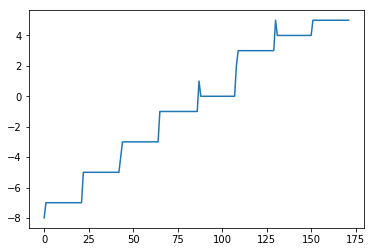

(362, 372256)
[ -2.10036799e-06  -2.35856431e-06  -1.94406361e-06 ...,   0.00000000e+00
   0.00000000e+00   0.00000000e+00]


In [84]:
#%matplotlib inline

frame_rate = 2048
hop_rate = int(frame_rate / 2) #rate at which indexes increase in the audio array
repeat_num = int(math.ceil(len(target)) / hop_rate) #how many times an audio array gets split up into frames
zeroes = np.zeros(1024) #buffer to increase size for audio array
target = np.append(target, zeroes) #appending target & zeroes
splitAudio = np.zeros([math.ceil(repeat_num), frame_rate]) #init array

for i in range(int(repeat_num)):
    for j in range(int(frame_rate)):
        splitAudio[i][j] = target[i * int(hop_rate) + j] #filling up overlapping frames into splitAudio
        


window = signal.triang(2048) #triangle window

outAudio = np.shape(len(target) - len(zeroes))

for i in range(repeat_num):
    temp_frame = splitAudio[i]
    splitAudio[i] = temp_frame * window #applying window to each overlapping frame

autotune_window = 2048 # window in which samples are pitch shifted

index = int(math.floor(len(base)/autotune_window)) #how many pitches will be in the final array

def cleanUp(x):
    root = -7 #?
    for i in range(len(x)):
        if abs(root - x[i]) > 10:
            x[i] = x[i] - 12
            root = x[i]
    return x

n_steps1 = np.zeros(index)
print()

for i in range(index): #applying pitch shift autotune
        n_steps1[i] = stepDistance(data_base[i*4],data_target[i*4])
        
n_steps1 = cleanUp(n_steps1)
print(n_steps1)
        
for i in range(index):
    splitAudio[i] = librosa.effects.pitch_shift(y=splitAudio[i], sr=sr, n_steps=n_steps1[i])
    
    
    
vector_audio = np.zeros((repeat_num,len(target)))

plt.plot(n_steps1)
plt.show()


    
    

for i in range(repeat_num): #amount of overlapping frames
    startIndex = i * hop_rate #index of where frame begins in time
    for j in range(frame_rate): #2048
        vector_audio[i][startIndex + j] = splitAudio[i][j] #filling vector with overlapping frames
        

        
print(vector_audio.shape)
        

out_audio = np.zeros(len(target)) #init final vector with zeros


for i in range(repeat_num):
    out_audio = np.add(out_audio,vector_audio[i]) #adding all vectors together
    
print(out_audio[:(len(out_audio)-hop_rate)])
        

In [82]:
IPython.display.Audio(data=out_audio, rate=sr)

In [70]:
IPython.display.Audio(data=splitAudio.flatten(), rate=sr)